In [61]:
# python standard library imports
# from-imports follow regular imports
import re
import random
from math import sqrt
from collections import Counter

# external libraries imports, grouped semantically
import torch
import numpy as np

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from IPython.display import clear_output, display

# Word2vec-CBOW tutorial

In this tutorial we will implement text pre-processing in a manner that is similar to how we pre-process text for neural networks and then we will train out own word vectors on our own dataset.

## Task 1
Find a dataset to train your word embeddings on. It should be more than 50 000 words after the pre-processing is done. To make the dataset you can use absolutely any text: wikipedia, movie scripts, books, reddit, twitter. The kinds of text you are using will affect your word embeddings flavor. You can use the same dataset we used in the class, but we encourage you to make your own dataset.

Useful links:

1. Learn more about python list comprehensions: https://www.programiz.com/python-programming/list-comprehension
1. Numerical instability of softmax: https://www.youtube.com/watch?v=99qLd2p6x5E

In [62]:
with open("star_wars_scripts.txt") as f:
    raw_data = f.read()

In [63]:
print(raw_data[:1000])

STAR WARS

                                        Episode IV

                                        A NEW HOPE

                                         From the
                                  JOURNAL OF THE WHILLS

                                            by
                                       George Lucas

                                   Revised Fourth Draft
                                     January 15, 1976

                                      LUCASFILM LTD.

                

               A long time ago, in a galaxy far, far, away...

               A vast sea of stars serves as the backdrop for the main title. 
               War drums echo through the heavens as a rollup slowly crawls 
               into infinity.

                    It is a period of civil war. Rebel spaceships, 
                    striking from a hidden base, have won their first 
                    victory against the evil Galactic Empire.

                    During the battle, Rebe

In [64]:
raw_data[:1000]

'STAR WARS\n\n                                        Episode IV\n\n                                        A NEW HOPE\n\n                                         From the\n                                  JOURNAL OF THE WHILLS\n\n                                            by\n                                       George Lucas\n\n                                   Revised Fourth Draft\n                                     January 15, 1976\n\n                                      LUCASFILM LTD.\n\n                \n\n               A long time ago, in a galaxy far, far, away...\n\n               A vast sea of stars serves as the backdrop for the main title. \n               War drums echo through the heavens as a rollup slowly crawls \n               into infinity.\n\n                    It is a period of civil war. Rebel spaceships, \n                    striking from a hidden base, have won their first \n                    victory against the evil Galactic Empire.\n\n             

# Preprocessing

In [65]:
def preprocess(text):
    text = text.lower()

    # Remove punctuation
    text = re.sub(r"[^\w\s]", "", text)

    # Replace multiple spaces with a single space
    text = re.sub(r"\s+", " ", text)
    return text


In [66]:
preprocessed_data = preprocess(raw_data)
preprocessed_data[:100]

'star wars episode iv a new hope from the journal of the whills by george lucas revised fourth draft '

In [67]:
def tokenize(text):
    return text.split(" ")

tokenized_data = tokenize(preprocessed_data)

print(f"Total number of words : {len(tokenized_data)}")
print(f"Number of unique words: {len(set(tokenized_data))}")
print(f"First 10 words", tokenized_data[:10])

Total number of words : 83522
Number of unique words: 6817
First 10 words ['star', 'wars', 'episode', 'iv', 'a', 'new', 'hope', 'from', 'the', 'journal']


In [68]:
word_counts = Counter(tokenized_data)
word_counts.most_common(10)

[('the', 5680),
 ('and', 2000),
 ('a', 1895),
 ('to', 1784),
 ('of', 1566),
 ('luke', 1325),
 ('in', 1013),
 ('his', 950),
 ('you', 905),
 ('han', 856)]

In [69]:
# least common
word_counts.most_common()[:-10-1:-1]

[('', 1),
 ('elsewhere', 1),
 ('midsts', 1),
 ('sidelines', 1),
 ('touch', 1),
 ('hardy', 1),
 ('greet', 1),
 ('hugged', 1),
 ('liberation', 1),
 ('communal', 1)]

In [70]:
rare_words = []
for word, count in word_counts.items():
    if count < 5:
        rare_words.append(word)

len(rare_words)

4927

After looking at the resulting word vectors we decided to remove some of the most frequent words too. While in general it is not a good idea, it works well for this homework.

In [71]:
frequent_words = ["the", "and", "a", "to", "of", "in", "his", "you", "is", "on", "i", "as", "he", "it", "at", "with", "into", "out", "him", "from", "for", "that", "be", "your", "by", "this", "an"]

In [72]:
vocabulary = set(tokenized_data) - set(rare_words) - set(frequent_words)
len(vocabulary)

1863

In [73]:
filtered_data = [w for w in tokenized_data if w in vocabulary]

print("Total number of words in the dataset after filtration: ", len(filtered_data))
assert len(filtered_data) > 50_000, "your dataset should have at least 50K words"

Total number of words in the dataset after filtration:  50916


# Word2vec CBOW idea:

Maximize in-context word similarity, while minimizing out-of-context word vector similarity.

Spefcifically:

$$
maximize \frac{e^{w \cdot w_{in context}}}{\sum e^{ w \cdot w_{out of context}}}
$$

In [74]:
window_size = 4

In [75]:
filtered_data[110:130]
# word: spacecraft, context: [tiny, silver, a, rebel]

['artoodetoo',
 'r2',
 'seethreepio',
 'struggle',
 'make',
 'their',
 'way',
 'through',
 'shaking',
 'bouncing',
 'passageway',
 'both',
 'robots',
 'are',
 'old',
 'battered',
 'artoo',
 'short',
 'face',
 'mass']

In [76]:
words_and_contexts = []  # list of tuples (word, list of context words)

for i, word in enumerate(filtered_data):
    if i < window_size:
        continue
    if i >= len(filtered_data) - window_size:
        break

    context = []
    for j in range(i - window_size, i + window_size + 1):
        if i == j: continue
        context.append(filtered_data[j])

    word_and_context = (word, context)
    words_and_contexts.append(word_and_context)

random.shuffle(words_and_contexts)
words_and_contexts[0]

('fire',
 ['take', 'thousand', 'ships', 'more', 'power', 'than', 'ive', 'signal'])


# (Too) simple (and too slow) word2vec implementation

```python
emb_size = 50

word2vec = dict()
for w in vocabulary:
    word2vec[w] = torch.randn(emb_size, requires_grad=True)
    
# training loop

for word, context in tqdm(words_and_contexts):
    word_vector = word2vec[word]
    context_vector = sum([word2vec[w] for w in context]) / len(context)

    nominator = torch.exp(word_vector @ context_vector.T)
    denominator = sum(torch.exp(context_vector @ word2vec[w].T) for w in vocabulary)

    loss = - nominator / denominator

    # update our word vectors using gradient descent to minimize loss
    # 1. compute gradients
    # 2. update vectors in the direction opposite to the gradient

    loss.backward()  # compute gadients

    with torch.no_grad():
        for w in word2vec.values():
            w -= w.grad
            w.grad = None

# TOO SLOW: one pass over data takes more than an hour!
```

# More realistic word2vec example

We going to change a couple of things from the naive implementation:

1. Use a single embedding matrix instead of a dicrionary `word2vec` that maps words to their vectors
2. Use matrix multiplication instead of for-loop

These two things will speed up computation by a factor of a hundred.

3. Use a numerically stable implementation of the loss function.

4. Update our vectors with a gradient averaged over 100 examples instead of a gradient of just one example.

5. Initialize word vectors with smaller numbers.

6. Carefully select **learning rate** parameter of gradient descent.

These four things (3-6) will help us to optimize word vectors without them becoming NaN.

7. We are going to train for longer to get better vectors

### About numerical stability

Remember that our loss looks like this:

$$
loss = -log \frac{e^{w \cdot c}}{\sum e^{w \cdot w_i}}
$$

which is basically a softmax operation

$$
softmax(x) = \frac{e^{x}}{\sum e^{x_i}}
$$

And naive implementation of softmax causes NaN when computed on large numbers. Watch [the video](https://youtu.be/99qLd2p6x5E?t=92) to understand why.

If you prefer reading to watching the videos, you can take a look at this [Stanford CS231n class note](https://cs231n.github.io/linear-classify/#softmax-classifier). Look for "Practical issues: Numeric stability".

### About word vector initialization

In the next lectures we will discuss why it's beneficial to initialize parameters like randn(size) / sqrt(size).
Short answer: large numbers cause divergences in optimization process. Meaning your loss goes to infinity or NaN which is just as bad. When you multiply two random vectors of size S distributed N(0, 1) you get a vector distribted N(0, S). To make this smaller we initialize vectors from $N(0, 1/S) = N(0, 1) / \sqrt{S}$ which gives us N(0, 1).



In [77]:
word2id = {}
for idx, word in enumerate(vocabulary):
    word2id[word] = idx


# (Too) simple (and too slow) word2vec implementation

'''
emb_size = 50

word2vec = dict()
for w in vocabulary:
    word2vec[w] = torch.randn(emb_size, requires_grad=True)
    
# training loop

for word, context in tqdm(words_and_contexts):
    word_vector = word2vec[word]
    context_vector = sum([word2vec[w] for w in context]) / len(context)

    nominator = torch.exp(word_vector @ context_vector.T)
    denominator = sum(torch.exp(context_vector @ word2vec[w].T) for w in vocabulary)

    loss = - nominator / denominator

    # update our word vectors using gradient descent to minimize loss
    # 1. compute gradients
    # 2. update vectors in the direction opposite to the gradient

    loss.backward()  # compute gadients

    with torch.no_grad():
        for w in word2vec.values():
            w -= w.grad
            w.grad = None

# TOO SLOW: one pass over data takes more than an hour!
'''   


def numerically_stable_loss(word_vector, context_vector, all_word_vectors):
    word_context_sim = word_vector @ context_vector.T
    word_vocab_sim = context_vector @ all_word_vectors.T

    # --- important part that makes computation numerically stable ---
    max_value = torch.max(word_vocab_sim)
    word_context_sim_normalized = word_context_sim - max_value
    word_vocab_sim_normalized = word_vocab_sim - max_value
    # ----------------------------------------------------------------

    nominator = torch.exp(word_context_sim_normalized)
    denominator = torch.sum(torch.exp(word_vocab_sim_normalized))

    loss = -torch.log(nominator / denominator)
    return loss

## Task 2:

This training loop is already working, your task is to understand how it works and to find `learning_rate` that gives you the best vectors in terms of the training loss. Also feel free to modify `emb_size`, `max_epochs` and `batch_size`, but usually learning rate is the most important parameter. Reasonable range for learning rate (in this specific case) is 1e-4 to 1.0, but feel free to try values outsize of that range as well.

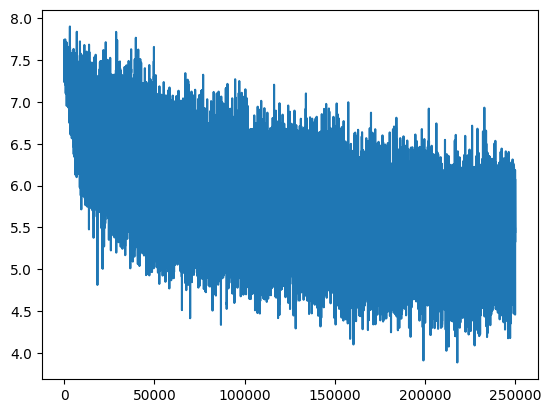

100%|██████████| 50908/50908 [00:13<00:00, 3759.00it/s]


Training finished


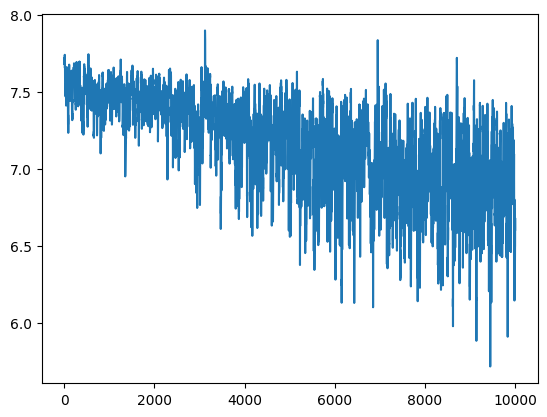

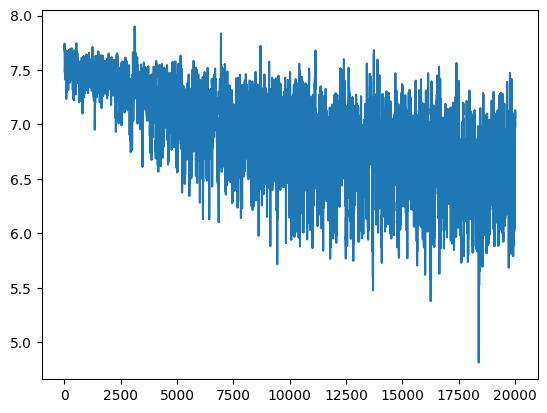

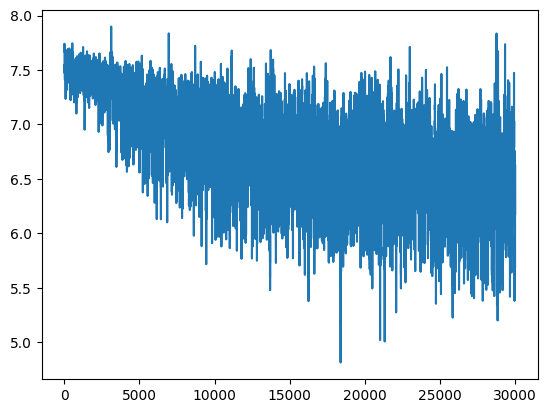

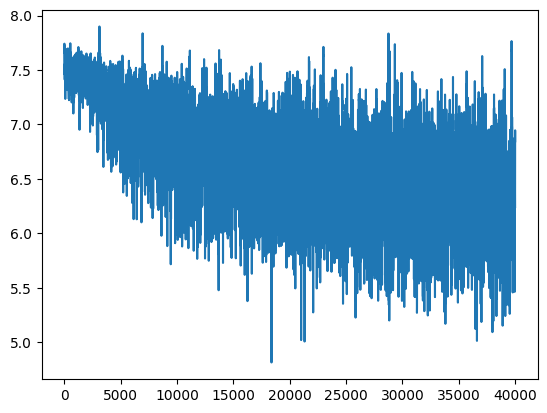

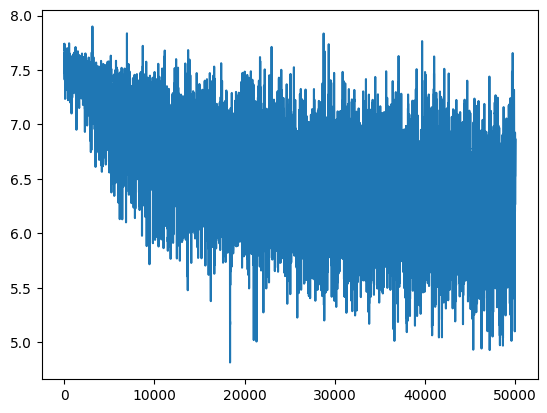

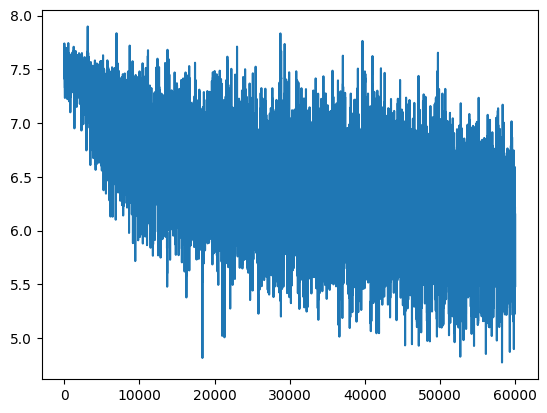

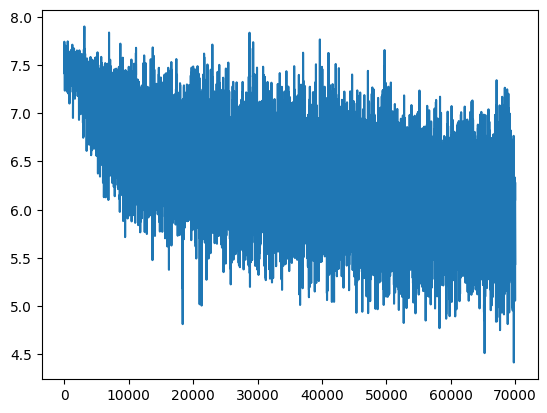

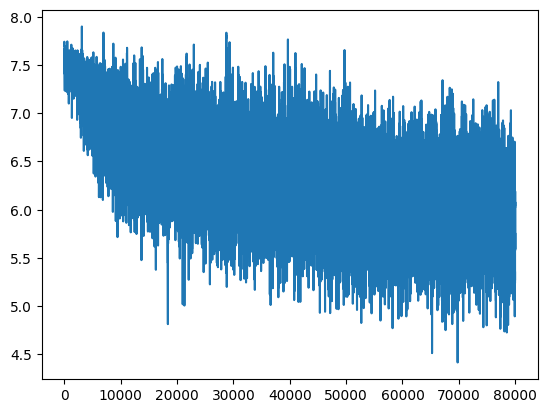

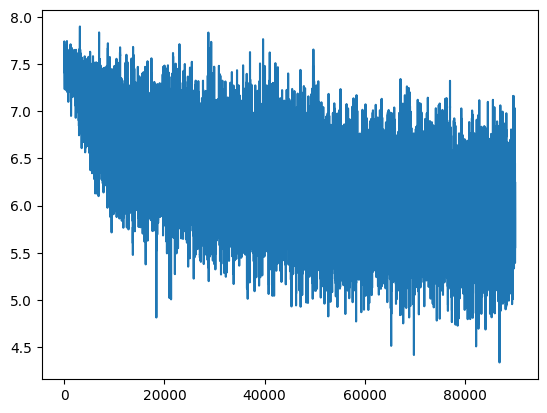

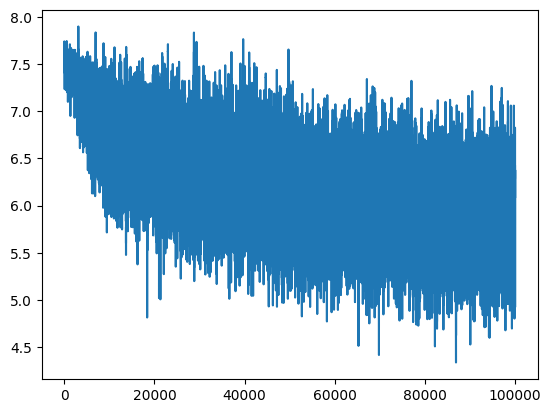

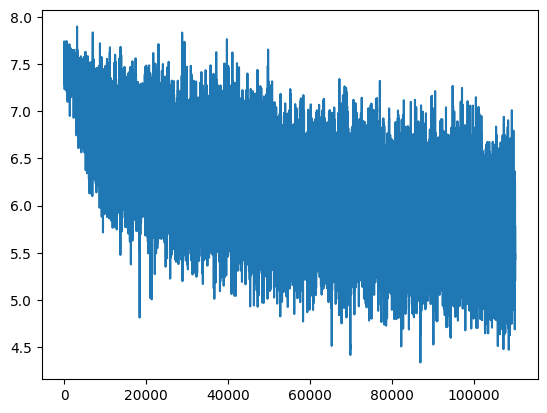

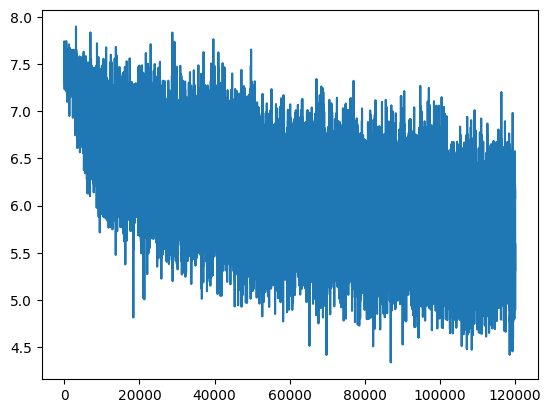

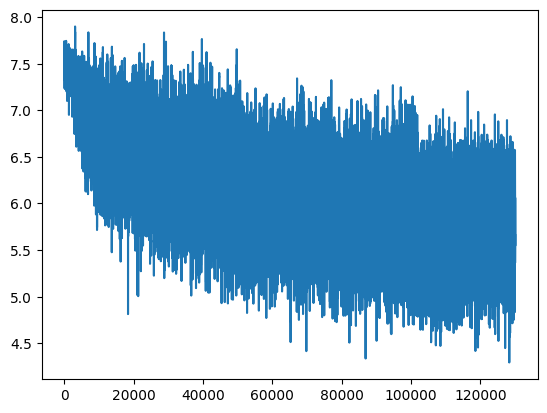

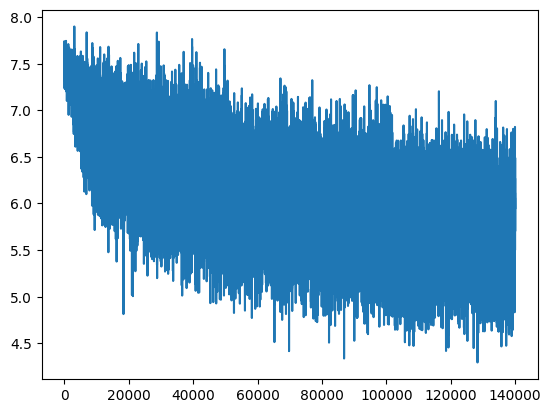

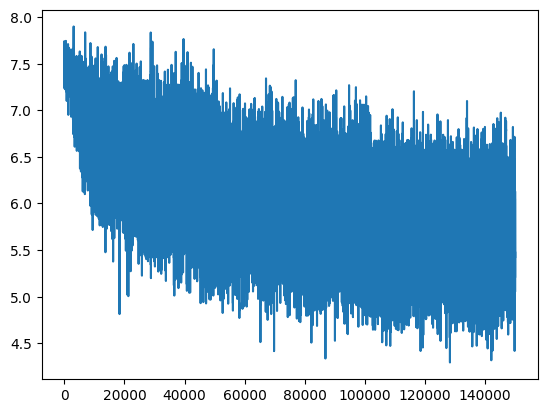

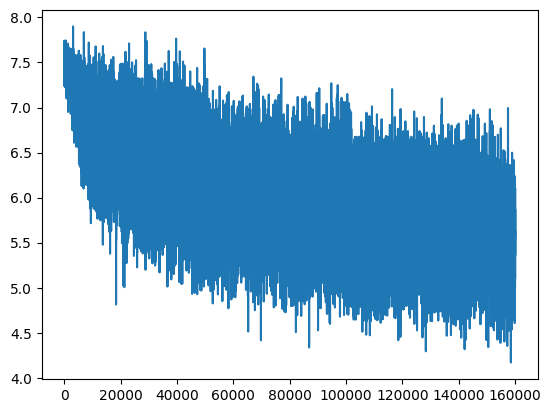

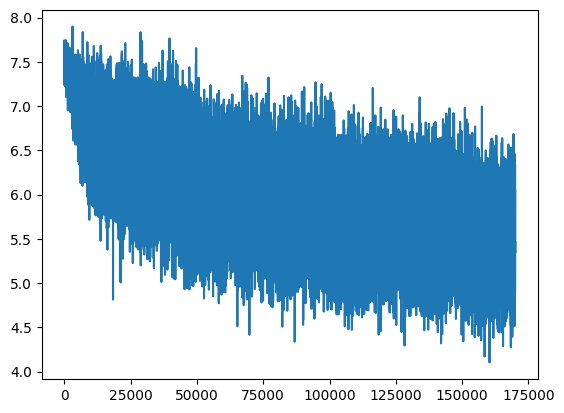

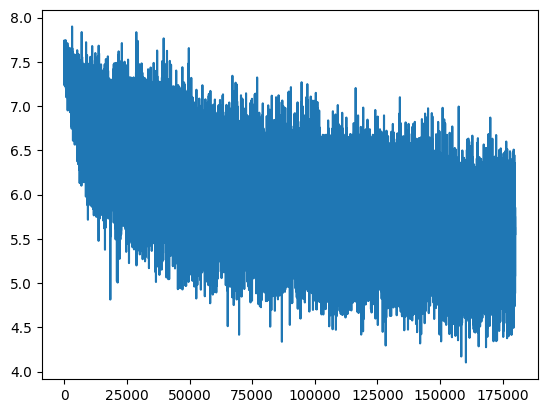

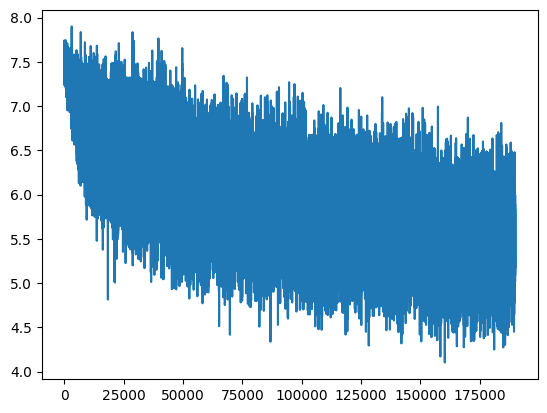

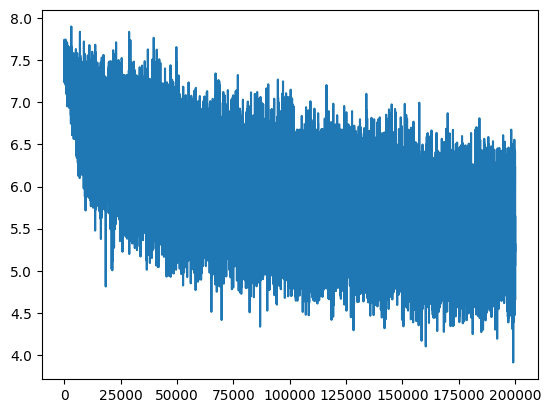

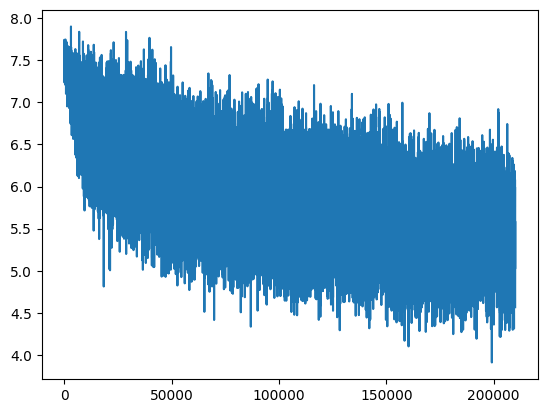

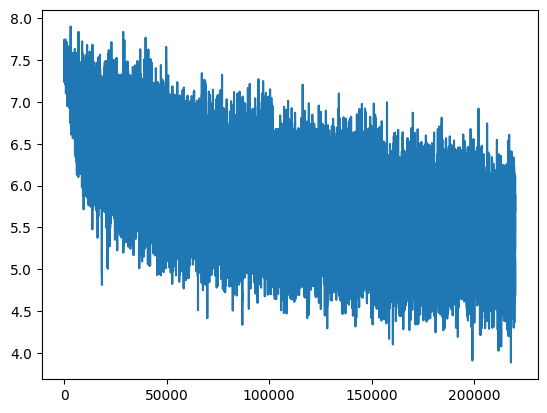

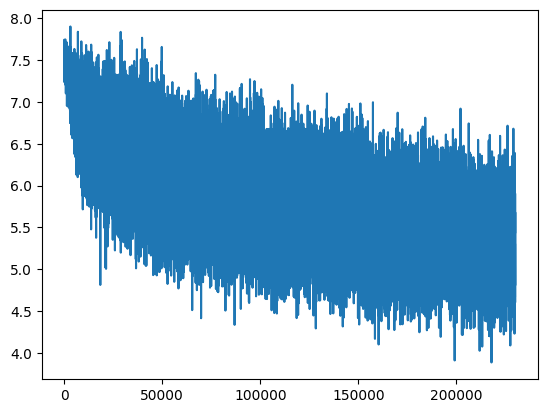

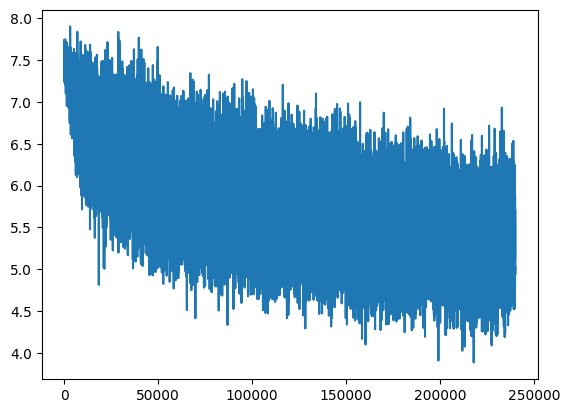

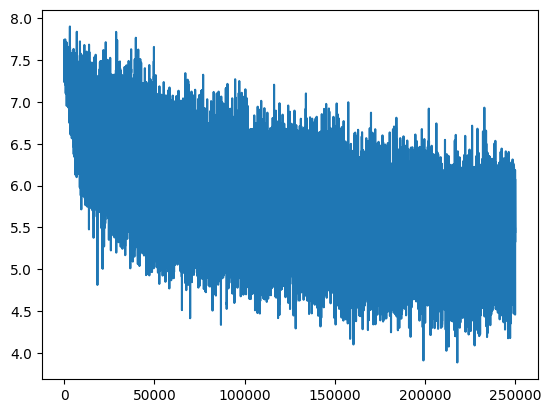

In [78]:
emb_size = 100 # Dimensionality of the vector e.g v^50
learning_rate = 0.5 # Larger = faster training , Slower = stable and slower training  

vocab_size = len(vocabulary)
batch_size = 64 # Num examples to calculate the gradient 

word_embeddings_init_value = np.random.randn(vocab_size, emb_size) / sqrt(emb_size)
word_embeddings = torch.tensor(word_embeddings_init_value, requires_grad=True, dtype=torch.float32)

global_step = 0

prev_loss_value = None
loss_hist = []
should_stop = False

for epoch in range(5):
    random.shuffle(words_and_contexts)  # shuffle the dataset
    print(f"Epoch {epoch}")
    if should_stop: break

    for word, context in tqdm(words_and_contexts):
        global_step += 1

        word_idx = word2id[word]
        context_idx = [word2id[w] for w in context]

        word_vector = word_embeddings[word_idx]
        context_vector = sum(word_embeddings[context_idx])

        loss = numerically_stable_loss(word_vector, context_vector, word_embeddings)

        # compute gadients at every step
        # every loss.backward() adds to the previous gradients
        # using multiple examples to get the gradient allows us to better estimate the true gradient over the whole dataset
        loss.backward()

        if torch.isnan(loss).item():
            print("Loss is None. Updating the vectors now will cause them to become NaN. Interrupting training.")
            should_stop = True
            break

        if global_step % batch_size == 0:
            with torch.no_grad():
                if torch.any(torch.isnan(word_embeddings.grad)):
                    print("Grad is None. Updating the vectors now will cause them to become NaN. Interrupting training.")
                    should_stop = True
                    break

                gradient = word_embeddings.grad
                gradient = gradient / batch_size  # average gradients over batch_size examples
                gradient = gradient.clamp(min=-5.0, max=5.0)  # fancy deep learning hack that we will learn in the next lectures
                word_embeddings -= learning_rate * gradient

                # zero out the gradients
                word_embeddings.grad = torch.zeros_like(word_embeddings.grad)

        if prev_loss_value is None:
            prev_loss_value = loss

        loss_to_log = loss * 0.1 + prev_loss_value * 0.9  # exponential smoohting to make the plots look nicer
        prev_loss_value = loss_to_log
        loss_hist.append(loss_to_log.item())  # .item() converts a single-value tensor to a regular python float

        if global_step % 10_000 == 0:
            # plots the loss so you can observe if it goes down or not
            clear_output()  # this will cause tqdm to disappear, sorry
            fig, ax = plt.subplots(1, 1)
            ax.plot(loss_hist)
            display(fig)

print("Training finished")

**More about task 2** We expect your loss to significantly decrease during training which should be visible on the plot above.

In [79]:
# Play with trained vectors

def get_word_vector(word_str):
    if word_str not in word2id:
        raise ValueError(f"Word {word_str} not in the vocabulary")

    return word_embeddings[word2id[word_str]]

In [80]:
luke = get_word_vector("luke")
force = get_word_vector("force")
spaceship = get_word_vector("spaceship")
vader = get_word_vector("vader")

In [81]:
# compute similarity of the word luke with the word force
luke @ force.T

tensor(0.5870, grad_fn=<DotBackward0>)

In [82]:
luke @ spaceship.T

tensor(0.2059, grad_fn=<DotBackward0>)

In [83]:
luke @ vader.T

tensor(0.9522, grad_fn=<DotBackward0>)

## Task 3:

Use word embeddings to find most similar words to these words:

1. luke
1. woman
1. star

If the above words are not in your vocabulary, feel free to use different ones.


> Because the dataset is small, it's likely that most similar words won't be perfect. Feel free to train on more data (get a bigger dataset).


To find most similar words to a word W compute the similarity with the rest of the words from the vocabulary. Print top-10 most similar words: most similar to least and the similarity value like this:

```
luke most similar:
luke similarity: 18.753528594970703
han similarity: 17.64794921875
leia similarity: 16.81419563293457
threepio similarity: 14.953056335449219
int similarity: 14.128015518188477
cockpit similarity: 12.512998580932617
star similarity: 11.790962219238281
artoo similarity: 11.107627868652344
chewie similarity: 10.742396354675293
death similarity: 10.645984649658203
```

In [84]:
# YOUR CODE HERE
# python standard library imports
# from-imports follow regular imports
import re
import random
from math import sqrt
from collections import Counter

# external libraries imports, grouped semantically
import torch
import numpy as np

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from IPython.display import clear_output, display

#  All nessecary functions

def preprocess(text):
    text = text.lower()

    # Remove punctuation
    text = re.sub(r"[^\w\s]", "", text)

    # Replace multiple spaces with a single space
    text = re.sub(r"\s+", " ", text)
    return text

def tokenize(text):
    return text.split(" ")

def find_most_similar(word , limit ):
    # Implement error checking
    '''
    if word not in word2id:
        raise ValueError(f"Word {word} not in the vocabulary")
    '''
    most_similar = []
    target_vector = get_word_vector(word)
    similarities = [
        (other_word, compute_similarity(target_vector, vector))
        for vector, other_word in word_vector_vocabulary
    ]
    most_similar = sorted(similarities, key=lambda x: x[1], reverse=True)[:limit]

    return most_similar

# Function to get similar words 
def get_word_vector(word_str):
    if word_str not in word2id:
        raise ValueError(f"Word {word_str} not in the vocabulary")

    return word_embeddings[word2id[word_str]]

def compute_similarity(vector1, vector2):
    return (vector1 @ vector2).item()

def numerically_stable_loss(word_vector, context_vector, all_word_vectors):
    word_context_sim = word_vector @ context_vector.T
    word_vocab_sim = context_vector @ all_word_vectors.T

    # --- important part that makes computation numerically stable ---
    max_value = torch.max(word_vocab_sim)
    word_context_sim_normalized = word_context_sim - max_value
    word_vocab_sim_normalized = word_vocab_sim - max_value
    # ----------------------------------------------------------------

    nominator = torch.exp(word_context_sim_normalized)
    denominator = torch.sum(torch.exp(word_vocab_sim_normalized))

    loss = -torch.log(nominator / denominator)
    return loss


with open("star_wars_scripts.txt") as f:
    raw_data = f.read()

# Tokenize and preprocess the data 
data = preprocess(raw_data)
tokenized_data = tokenize(data)
word_counts = Counter(tokenized_data)
frequent_words = ["the", "and", "a", "to", "of", "in", "his", "you", "is", "on", "i", "as", "he", "it", "at", "with", "into", "out", "him", "from", "for", "that", "be", "your", "by", "this", "an"]
rare_words = []
for word, count in word_counts.items():
    if count < 5:
        rare_words.append(word)

vocabulary = set(tokenized_data) - set(rare_words) - set(frequent_words)
filtered_data = [w for w in tokenized_data if w in vocabulary]


word2id = {}
for idx, word in enumerate(vocabulary):
    word2id[word] = idx

emb_size = 100
learning_rate = 0.02

vocab_size = len(vocabulary)
print("Vocab Size" , vocab_size)
batch_size = 128

word_embeddings_init_value = np.random.randn(vocab_size, emb_size) / sqrt(emb_size)
word_embeddings = torch.tensor(word_embeddings_init_value, requires_grad=True, dtype=torch.float32)

global_step = 0

prev_loss_value = None
loss_hist = []
should_stop = False

words_and_contexts = []

for epoch in range(5):
    random.shuffle(words_and_contexts)  # shuffle the dataset
    print(f"Epoch {epoch}")
    if should_stop: break

    for word, context in tqdm(words_and_contexts):
        global_step += 1

        word_idx = word2id[word]
        context_idx = [word2id[w] for w in context]

        word_vector = word_embeddings[word_idx]
        context_vector = sum(word_embeddings[context_idx])

        loss = numerically_stable_loss(word_vector, context_vector, word_embeddings)
        print("Loss is " , loss)

        # compute gadients at every step
        # every loss.backward() adds to the previous gradients
        # using multiple examples to get the gradient allows us to better estimate the true gradient over the whole dataset
        loss.backward()

        if torch.isnan(loss).item():
            print("Loss is None. Updating the vectors now will cause them to become NaN. Interrupting training.")
            should_stop = True
            break

        if global_step % batch_size == 0:
            with torch.no_grad():
                if torch.any(torch.isnan(word_embeddings.grad)):
                    print("Grad is None. Updating the vectors now will cause them to become NaN. Interrupting training.")
                    should_stop = True
                    break

                gradient = word_embeddings.grad
                gradient = gradient / batch_size  # average gradients over batch_size examples
                gradient = gradient.clamp(min=-5.0, max=5.0)  # fancy deep learning hack that we will learn in the next lectures
                word_embeddings -= learning_rate * gradient

                # zero out the gradients
                word_embeddings.grad = torch.zeros_like(word_embeddings.grad)

        if prev_loss_value is None:
            prev_loss_value = loss

        loss_to_log = loss * 0.1 + prev_loss_value * 0.9  # exponential smoohting to make the plots look nicer
        prev_loss_value = loss_to_log
        loss_hist.append(loss_to_log.item())  # .item() converts a single-value tensor to a regular python float

        if global_step % 10_000 == 0:
            # plots the loss so you can observe if it goes down or not
            clear_output()  # this will cause tqdm to disappear, sorry
            fig, ax = plt.subplots(1, 1)
            ax.plot(loss_hist)
            display(fig)



# Need to convert vocabulary to word vector 
word_vector_vocabulary = []
for word in vocabulary:
    word_vector_vocabulary.append((get_word_vector(word), word))






words = ["luke" , "woman" , "star"]
# Can remove below now 
luke = get_word_vector(words[0])
woman = get_word_vector(words[1])
star= get_word_vector(words[2])




print("-------------------------------------")
print("             Simalarity              ")
# Do this in a more eifficent way

mostSimilar1 = find_most_similar(words[0],10)
mostSimilar2 = find_most_similar(words[1],10)
mostSimilar3 = find_most_similar(words[2],10)
allSimilaritys = [mostSimilar1,mostSimilar2,mostSimilar3]
for i in range(len(words)):
    mostSimilar = find_most_similar(words[i],10)
    print(words[i], " most similar : ")
    currentword = allSimilaritys[i]
    for j in range(10):
        currentwordname = [currentword[j][:1]]
        formattedcurrentwordname = currentwordname[0][0]
        currentwordranking = [currentword[j][1:]]
        formattedcurrentwordranking = currentwordranking[0][0]
        print(formattedcurrentwordname ,"similarity:",formattedcurrentwordranking )

Vocab Size 1863
Epoch 0


0it [00:00, ?it/s]


Epoch 1


0it [00:00, ?it/s]


Epoch 2


0it [00:00, ?it/s]


Epoch 3


0it [00:00, ?it/s]


Epoch 4


0it [00:00, ?it/s]

-------------------------------------
             Simalarity              
luke  most similar : 
luke similarity: 1.1372349262237549
owen similarity: 0.36051464080810547
room similarity: 0.33210325241088867
twin similarity: 0.3164805769920349
dangerous similarity: 0.3080470860004425
anyone similarity: 0.29777830839157104
console similarity: 0.28790929913520813
drops similarity: 0.28391844034194946
swings similarity: 0.28203052282333374
return similarity: 0.2756573259830475
woman  most similar : 
woman similarity: 0.9107373356819153
escape similarity: 0.29728326201438904
chance similarity: 0.2820640802383423
wildly similarity: 0.26957789063453674
pod similarity: 0.2695399522781372
anakin similarity: 0.2617679834365845
small similarity: 0.24893860518932343
bridge similarity: 0.24449677765369415
here similarity: 0.2387389838695526
rebels similarity: 0.23783524334430695
star  most similar : 
star similarity: 1.0394173860549927
steaming similarity: 0.39843592047691345
dodonna similarity: 0

# Submission instructions

As in the first homework, execute the notebook top-to-bottom and submit it to the blackboard.